# Limpieza del Registro de Defunciones 2023

En este notebook vamos a:

- Definir reglas **claras de limpieza** basadas en lo que vimos en la exploración.
- Construir un **dataset limpio** para análisis y modelos.
- Preparar un subconjunto pensado para el escenario de **3 "hospitales" clientes**.

La idea es que este notebook deje listo un dataset sobre el cual luego podamos:
- Diseñar el problema de clasificación de causas de muerte.
- Definir los nodos federados (3 clientes) de manera consistente con los datos reales.

## 1. Importación de librerías y rutas

Cargamos las librerías a usar, configuramos gráficos y definimos las rutas del proyecto. Asumimos la misma estructura que en el EDA:

- `../data/raw/INEC_DEFUNCIONESGENERALES_2023.csv`
- `../data/processed/` para guardar versiones limpias.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('default')
sns.set(style='whitegrid')

pd.set_option('display.max_colwidth', 120)

PROJECT_ROOT = Path('..').resolve()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

csv_path = DATA_RAW / 'INEC_DEFUNCIONESGENERALES_2023.csv'
csv_path

WindowsPath('D:/Archivos de Usuario/Documents/defunciones-fl-ec/data/raw/INEC_DEFUNCIONESGENERALES_2023.csv')

## 2. Carga del dataset

In [2]:
df_raw = pd.read_csv(
    csv_path,
    sep=';',
    encoding='utf-8-sig',
    dtype=str
)
df_raw.shape, df_raw.columns

((89877, 45),
 Index(['Numeración', 'prov_insc', 'cant_insc', 'parr_insc', 'anio_insc',
        'mes_insc', 'dia_insc', 'fecha_insc', 'nac_fall', 'cod_pais', 'sexo',
        'anio_nac', 'mes_nac', 'dia_nac', 'fecha_nac', 'anio_fall', 'mes_fall',
        'dia_fall', 'fecha_fall', 'cod_edad', 'edad', 'prov_res', 'sabe_leer',
        'etnia', 'lugar_ocur', 'prov_fall', 'cant_fall', 'parr_fall',
        'muj_fertil', 'mor_viol', 'lug_viol', 'autopsia', 'causa4', 'cer_por',
        'area_fall', 'area_res', 'est_civil', 'niv_inst', 'residente', 'causa',
        'lc1', 'causa103', 'causa80', 'causa67A', 'causa67B'],
       dtype='object'))

Para evitar modificar accidentalmente el DataFrame original, trabajaremos sobre una copia llamada `df`.

In [3]:
df = df_raw.copy()

if "Numeración" in df.columns:
    df = df.drop(columns=["Numeración"])

df.head(3)

,prov_insc,cant_insc,parr_insc,anio_insc,mes_insc,dia_insc,fecha_insc,nac_fall,cod_pais,sexo,...,area_res,est_civil,niv_inst,residente,causa,lc1,causa103,causa80,causa67A,causa67B
0,Guayas,Naranjal,Naranjal,2024,Enero,25,25/1/2024,Ecuatoriana,Ecuador,Hombre,...,Urbano,Viudo (a),Secundaria,No residente,I63 Infarto cerebral,42 Enfermedades cerebrovasculares,069 Enfermedades Cerebro vasculares,055 Enfermedades cerebro vasculares,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio
1,Imbabura,Otavalo,Jordán,2023,Noviembre,27,27/11/2023,Ecuatoriana,Ecuador,Hombre,...,Urbano,Viudo (a),Educación Básica,Residente,I27 Otras enfermedades cardiopulmonares,36 Enfermedad cardiopulmonar y enfermedad de la circulación pulmonar,068 Otras enfermedades del corazón,054 Otras Enfermedades del corazón,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio
2,Cotopaxi,Latacunga,La Matriz,2023,Agosto,4,4/8/2023,Ecuatoriana,Ecuador,Hombre,...,Rural,Viudo (a),Educación Básica,Residente,I62 Otras hemorragias intracraneales no traumáticas,42 Enfermedades cerebrovasculares,069 Enfermedades Cerebro vasculares,055 Enfermedades cerebro vasculares,030 Enfermedades del sistema circulatorio,030 Enfermedades del sistema circulatorio


## 3. Decisiones de limpieza basadas en el EDA

A partir del EDA, tomamos las siguientes decisiones:

1. **Año de fallecimiento**: el archivo incluye defunciones con `anio_fall` entre 1898 y 2023, pero el 97%+ de los casos son 2023.
   - Para tener un corte claro y consistente, nos quedamos **solo con `anio_fall == '2023'`**.

2. **Fechas**:
   - Hay valores especiales como `9999/99/99` en `fecha_nac`.
   - Vamos a parsear las fechas (nacimiento y fallecimiento) y dejar en `NaT` las que no se puedan leer.

3. **Edad**:
   - `cod_edad` puede ser `Años`, `Meses`, `Días`, `Horas` o `Sin información`.
   - Construimos una variable continua `edad_anos` que convierte todo a años:
     - Años → igual.
     - Meses → meses/12.
     - Días → días/365.
     - Horas → horas/(24*365).
   - De esta forma tenemos una edad comparable para todos los casos.

4. **Valores 'Sin información' y vacíos**:
   - En variables como `etnia`, `sabe_leer`, `niv_inst`, `muj_fertil`, `autopsia` y otras, aparece explícitamente `'Sin información'` o cadenas vacías.
   - Vamos a estandarizar:
     - `''`, `' '` y `'Sin información'` → `NaN` en muchas variables categóricas.

5. **Causa de muerte (objetivo)**:
   - `causa103` tiene 84 grupos distintos.
   - Para un primer problema, definimos una variable de salida **agregada**:
     - Tomamos las **K causas más frecuentes** (por ejemplo K=10).
     - Todas las demás se agrupan en `'Otras causas'`.
   - Esto nos da una clasificación multiclase manejable.

6. **Enfoque en muertes en establecimientos de salud** (pensando en “hospitales”):
   - Nos interesa más el contexto hospitalario que las muertes en casa o en vía pública.
   - Vamos a seleccionar un subconjunto donde `lugar_ocur` corresponda a instituciones de salud u otros establecimientos.
   - Dentro de ese subconjunto, más adelante vamos a construir **3 clientes** basados en combinaciones reales de:
     - provincia de fallecimiento (`prov_fall`),
     - cantón de fallecimiento (`cant_fall`),
     - tipo de establecimiento (`lugar_ocur`).

## 4. Filtrado por año de fallecimiento (solo 2023)

Nos quedamos únicamente con las defunciones cuyo `anio_fall` es `"2023"`. Esto elimina arrastres de años anteriores.

In [4]:
df_2023 = df[df['anio_fall'] == '2023'].copy()
df_2023.shape

(87733, 44)

## 5. Limpieza básica de espacios y valores especiales

Antes de otras transformaciones, limpiamos espacios en blanco y normalizamos algunos valores especiales.

In [5]:
# Quitamos espacios al inicio y al final en todas las columnas texto
for col in df_2023.columns:
    df_2023[col] = df_2023[col].astype(str).str.strip()

# Definimos una función para reemplazar valores tipo "Sin información" por NaN
def normalizar_sin_info(serie):
    serie = serie.replace({'Sin información': np.nan, '': np.nan, ' ': np.nan})
    return serie

cols_sin_info = ['nac_fall', 'etnia', 'sabe_leer', 'muj_fertil', 'mor_viol', 'lug_viol',
                 'autopsia', 'est_civil', 'niv_inst']

for col in cols_sin_info:
    if col in df_2023.columns:
        df_2023[col] = normalizar_sin_info(df_2023[col])

df_2023[cols_sin_info].head(5)

,nac_fall,etnia,sabe_leer,muj_fertil,mor_viol,lug_viol,autopsia,est_civil,niv_inst
0,Ecuatoriana,Mestizo (a),Si,NaN,NaN,NaN,No,Viudo (a),Secundaria
1,Ecuatoriana,Indígena,Si,NaN,NaN,NaN,No,Viudo (a),Educación Básica
2,Ecuatoriana,Mestizo (a),Si,NaN,NaN,NaN,No,Viudo (a),Educación Básica
3,Ecuatoriana,Mestizo (a),NaN,NaN,NaN,NaN,No,Viudo (a),NaN
4,Ecuatoriana,Mestizo (a),No,NaN,NaN,NaN,No,Viudo (a),Ninguno


## 6. Conversión y estandarización de edad

Vamos a crear una nueva columna `edad_anos` que exprese la edad en años (posiblemente con decimales), usando `cod_edad`:

- Si `cod_edad == 'Años'` → `edad_anos = edad`.
- Si `cod_edad == 'Meses'` → `edad_anos = edad / 12`.
- Si `cod_edad == 'Días'` → `edad_anos = edad / 365`.
- Si `cod_edad == 'Horas'` → `edad_anos = edad / (24*365)`.
- Si `cod_edad == 'Sin información'` → `NaN`.

Después revisamos un resumen estadístico de `edad_anos` para ver que todo tenga sentido.

In [6]:
df_2023['edad_num'] = pd.to_numeric(df_2023['edad'], errors='coerce')

def convertir_edad_a_anios(row):
    cod = row['cod_edad']
    edad = row['edad_num']
    if pd.isna(edad):
        return np.nan
    if cod == 'Años':
        return edad
    if cod == 'Meses':
        return edad / 12.0
    if cod == 'Días':
        return edad / 365.0
    if cod == 'Horas':
        return edad / (24.0 * 365.0)
    return np.nan

df_2023['edad_anos'] = df_2023.apply(convertir_edad_a_anios, axis=1)
df_2023['edad_anos'].describe()

count    87716.000000
mean        62.887427
std         25.723017
min          0.000000
25%         45.000000
50%         69.000000
75%         83.000000
max        120.000000
Name: edad_anos, dtype: float64

Podemos ver rápidamente la distribución de `edad_anos` para confirmar que no hay valores totalmente fuera de rango.

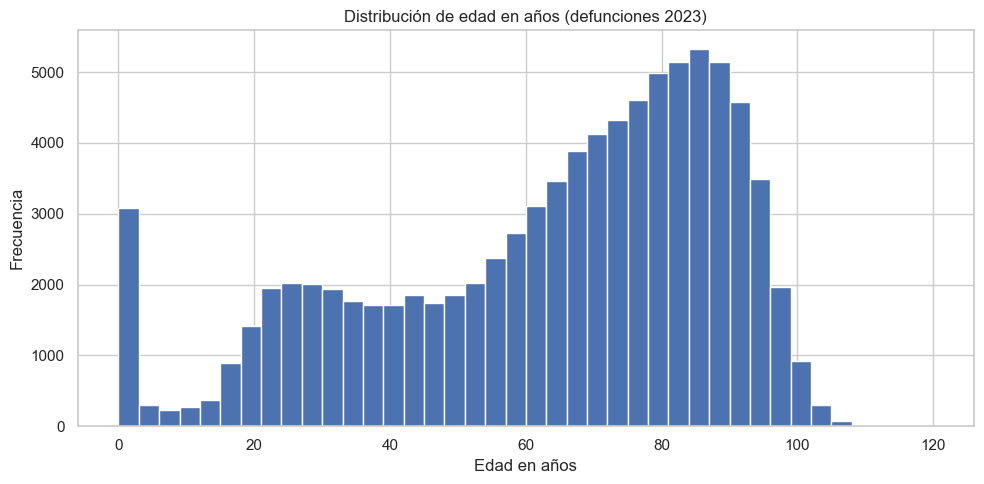

In [7]:
plt.figure(figsize=(10,5))
df_2023['edad_anos'].plot(kind='hist', bins=40)
plt.title('Distribución de edad en años (defunciones 2023)')
plt.xlabel('Edad en años')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## 7. Parsing de fechas de nacimiento y fallecimiento

Convertimos `fecha_nac` y `fecha_fall` a formato fecha (`datetime`).
Valores como `9999/99/99` quedarán como `NaT`.

In [8]:
df_2023['fecha_nac_dt'] = pd.to_datetime(df_2023['fecha_nac'], format='%d/%m/%Y', errors='coerce')
df_2023['fecha_fall_dt'] = pd.to_datetime(df_2023['fecha_fall'], format='%d/%m/%Y', errors='coerce')

df_2023[['fecha_nac', 'fecha_nac_dt', 'fecha_fall', 'fecha_fall_dt']].head(10)

,fecha_nac,fecha_nac_dt,fecha_fall,fecha_fall_dt
0,18/7/1931,1931-07-18,30/12/2023,2023-12-30
1,26/9/1926,1926-09-26,24/11/2023,2023-11-24
2,9/4/1929,1929-04-09,4/8/2023,2023-08-04
3,8/8/1955,1955-08-08,8/10/2023,2023-10-08
4,22/5/1941,1941-05-22,27/9/2023,2023-09-27
5,12/11/1936,1936-11-12,7/9/2023,2023-09-07
6,25/10/1925,1925-10-25,13/11/2023,2023-11-13
7,7/5/1952,1952-05-07,14/10/2023,2023-10-14
8,26/9/1946,1946-09-26,26/11/2023,2023-11-26
9,16/5/1931,1931-05-16,30/11/2023,2023-11-30


Podemos calcular la proporción de fechas no parseadas para ver qué tan fiable es cada campo.

In [9]:
prop_nac_na = df_2023['fecha_nac_dt'].isna().mean()
prop_fall_na = df_2023['fecha_fall_dt'].isna().mean()
prop_nac_na, prop_fall_na

(np.float64(0.0008548664698574083), np.float64(0.0))

## 8. Normalización de variables categóricas clave

En esta sección estandarizamos algunas variables categóricas que usaremos como posibles predictores:

- `sexo`: lo dejamos tal como está (`Hombre`, `Mujer`).
- `etnia`: ya normalizamos los `Sin información` a `NaN`.
- `sabe_leer`: nos quedamos con valores `Si`/`No` y tratamos el resto como `NaN`.
- `niv_inst`: convertimos `Sin información` y vacío a `NaN` (ya hecho antes).
- `area_res`, `area_fall`: se mantienen (`Urbano`, `Rural`).
- `residente`: puede ser útil para distinguir residentes vs no residentes.
- `lugar_ocur`: definiremos un conjunto de lugares "tipo hospital".

Aquí solo revisamos rápidamente algunas distribuciones después de la normalización básica.

In [10]:
# Aseguramos que sabe_leer solo tenga Si/No o NaN
df_2023['sabe_leer'] = df_2023['sabe_leer'].where(df_2023['sabe_leer'].isin(['Si', 'No']), np.nan)

df_2023['sexo'].value_counts(dropna=False), df_2023['etnia'].value_counts(dropna=False).head(10)

(sexo
 Hombre    50822
 Mujer     36911
 Name: count, dtype: int64,
 etnia
 Mestizo (a)                              72281
 NaN                                       5841
 Indígena                                  3900
 Montubio (a)                              2473
 Afroecuatoriano (a) /Afrodescendiente     1121
 Blanco (a)                                1030
 Negro (a)                                  592
 Mulato  (a)                                370
 Otra                                       125
 Name: count, dtype: int64)

In [11]:
df_2023['sabe_leer'].value_counts(dropna=False), df_2023['niv_inst'].value_counts(dropna=False).head(10)

(sabe_leer
 Si     65068
 No     12927
 NaN     9738
 Name: count, dtype: int64,
 niv_inst
 Educación Básica                  25020
 Primaria                          15419
 Ninguno                           13159
 Educación Media / Bachillerato    11522
 NaN                               10400
 Secundaria                         5998
 Superior universitario             4429
 Centro de alfabetización            872
 Superior no universitario           727
 Postgrado                           187
 Name: count, dtype: int64)

## 9. Definición del objetivo: agrupación de causas (causa103)

Usaremos `causa103` como base para nuestro objetivo, pero tiene 80+ categorías, lo cual es mucho para un primer modelo.

Decisión:
- Tomamos las **10 causas más frecuentes** en `causa103`.
- Creamos una nueva columna `causa103_grouped`:
  - Si la causa está dentro del top 10 → se queda tal cual.
  - En caso contrario → `Otras causas`.

Esto genera un problema de clasificación multiclase con 11 clases (10 específicas + 1 categoría residual).

In [12]:
causa_counts = df_2023['causa103'].value_counts()
top_k = 10
top_causas = causa_counts.head(top_k).index.tolist()
top_causas

['067 Enfermedades isquémicas del corazón',
 '102 Agresiones',
 '069 Enfermedades Cerebro vasculares',
 '052 Diabetes mellitus',
 '096 Accidentes de transporte',
 '074 Neumonia',
 '066 Enfermedades hipertensivas',
 '086 Resto de enfermedades del sistema genitourinario',
 '094 Sintomas, signos y hallazgos anormales  clínicos yde laboratorio  no clasificados en otra parte',
 '080 Enfermedades del hígado']

In [13]:
def agrupar_causa(c):
    if pd.isna(c):
        return np.nan
    if c in top_causas:
        return c
    return 'Otras causas'

df_2023['causa103_grouped'] = df_2023['causa103'].apply(agrupar_causa)
df_2023['causa103_grouped'].value_counts(dropna=False)

causa103_grouped
Otras causas                                                                                           38649
067 Enfermedades isquémicas del corazón                                                                13318
102 Agresiones                                                                                          7308
069 Enfermedades Cerebro vasculares                                                                     4632
052 Diabetes mellitus                                                                                   4460
096 Accidentes de transporte                                                                            3984
074 Neumonia                                                                                            3743
066 Enfermedades hipertensivas                                                                          3537
086 Resto de enfermedades del sistema genitourinario                                                    2757
09

En esta etapa podemos revisar las proporciones de cada clase para ver si el problema está muy desbalanceado o si hay una distribución razonable.

In [14]:
df_2023['causa103_grouped'].value_counts(normalize=True) * 100

causa103_grouped
Otras causas                                                                                           44.052979
067 Enfermedades isquémicas del corazón                                                                15.180149
102 Agresiones                                                                                          8.329819
069 Enfermedades Cerebro vasculares                                                                     5.279655
052 Diabetes mellitus                                                                                   5.083606
096 Accidentes de transporte                                                                            4.541051
074 Neumonia                                                                                            4.266354
066 Enfermedades hipertensivas                                                                          4.031550
086 Resto de enfermedades del sistema genitourinario                           

## 10. Filtro de registros con objetivo válido

Nos quedamos solo con los registros donde `causa103_grouped` no es nulo.
Esto garantiza que todos los casos del dataset limpio tengan una etiqueta de causa utilizable para modelos.

In [15]:
df_model_base = df_2023[df_2023['causa103_grouped'].notna()].copy()
df_model_base.shape

(87733, 49)

## 11. Subconjunto orientado a establecimientos de salud

Para acercarnos a la idea de "hospitales clientes" en aprendizaje federado, nos centramos en defunciones ocurridas en establecimientos de salud u otras instituciones.

Según `lugar_ocur`, consideramos como **tipo hospitalario**:

- `Establecimientos del Ministerio de Salud`
- `Establecimientos del IESS`
- `Hospital, clínica o consultorio privado`
- `Establecimientos de la Junta de Beneficencia`
- `Otros establecimientos públicos`

Excluimos, por ejemplo, defunciones en `Casa` u `Otro`, para mantener el enfoque en el sistema de salud formal.

In [16]:
lugares_hospital = [
    'Establecimientos del Ministerio de Salud',
    'Establecimientos del IESS',
    'Hospital, clínica o consultorio privado',
    'Establecimientos de la Junta de Beneficencia',
    'Otros establecimientos públicos'
]

df_hosp = df_model_base[df_model_base['lugar_ocur'].isin(lugares_hospital)].copy()
df_hosp['lugar_ocur'].value_counts(dropna=False)

lugar_ocur
Establecimientos del Ministerio de Salud        19668
Establecimientos del IESS                        8649
Hospital, clínica o consultorio privado          8021
Establecimientos de la Junta de Beneficencia      983
Otros establecimientos públicos                   513
Name: count, dtype: int64

## 12. Definición de 3 "clientes-hospital" basados en los datos

El dataset no trae el nombre del hospital, pero sí tenemos:
- `prov_fall`: provincia donde ocurrió la defunción.
- `cant_fall`: cantón.
- `lugar_ocur`: tipo de establecimiento.

Para definir 3 clientes de forma **data-driven** y sin inventar nada, hacemos lo siguiente:

1. Contamos cuántas defunciones hay por combinación (`prov_fall`, `cant_fall`, `lugar_ocur`).
2. Ordenamos de mayor a menor.
3. Tomamos las **3 combinaciones más frecuentes** como nuestros 3 "hospitales cliente".

Estas combinaciones pueden corresponder, por ejemplo, a grandes hospitales públicos o privados en provincias con mucha carga (como Guayas o Pichincha), pero la elección sale directamente de los datos.

In [17]:
combos = (
    df_hosp
    .groupby(['prov_fall', 'cant_fall', 'lugar_ocur'])
    .size()
    .sort_values(ascending=False)
)
combos.head(10)

prov_fall  cant_fall   lugar_ocur                                  
Guayas     Guayaquil   Establecimientos del Ministerio de Salud        5531
Pichincha  Quito       Establecimientos del Ministerio de Salud        3003
Guayas     Guayaquil   Establecimientos del IESS                       2368
Pichincha  Quito       Establecimientos del IESS                       2052
Guayas     Guayaquil   Hospital, clínica o consultorio privado         2050
Pichincha  Quito       Hospital, clínica o consultorio privado         1575
Guayas     Guayaquil   Establecimientos de la Junta de Beneficencia     981
Manabí     Portoviejo  Establecimientos del Ministerio de Salud         782
Azuay      Cuenca      Establecimientos del IESS                        769
Manabí     Portoviejo  Hospital, clínica o consultorio privado          749
dtype: int64

Tomamos las 3 combinaciones con más registros como nuestros clientes. Luego creamos una columna `hospital_cliente` que etiqueta cada registro como:
- `'Hospital_1'`, `'Hospital_2'`, `'Hospital_3'` para dichas combinaciones.
- `NaN` para los demás (que no usaremos en la fase federada básica).

In [18]:
# Obtenemos las 3 combinaciones top
top3_combos = combos.head(3).index.tolist()
top3_combos

[('Guayas', 'Guayaquil', 'Establecimientos del Ministerio de Salud'),
 ('Pichincha', 'Quito', 'Establecimientos del Ministerio de Salud'),
 ('Guayas', 'Guayaquil', 'Establecimientos del IESS')]

In [19]:
def asignar_hospital(row, combos_top):
    key = (row['prov_fall'], row['cant_fall'], row['lugar_ocur'])
    if key == combos_top[0]:
        return 'Hospital_1'
    if key == combos_top[1]:
        return 'Hospital_2'
    if key == combos_top[2]:
        return 'Hospital_3'
    return np.nan

df_hosp['hospital_cliente'] = df_hosp.apply(asignar_hospital, axis=1, combos_top=top3_combos)
df_hosp['hospital_cliente'].value_counts(dropna=False)

hospital_cliente
NaN           26932
Hospital_1     5531
Hospital_2     3003
Hospital_3     2368
Name: count, dtype: int64

Nos quedamos ahora con el subconjunto que pertenece a alguno de los 3 clientes definidos. Este será el **dataset base para los experimentos de aprendizaje federado**, donde cada cliente representa un hospital distinto.

In [20]:
df_hosp_clients = df_hosp[df_hosp['hospital_cliente'].notna()].copy()
df_hosp_clients['hospital_cliente'].value_counts()

hospital_cliente
Hospital_1    5531
Hospital_2    3003
Hospital_3    2368
Name: count, dtype: int64

También revisamos la distribución de la variable objetivo `causa103_grouped` dentro de cada uno de los 3 hospitales. Esto nos dará una idea de qué tan **no-IID** (desbalanceada y distinta) es la distribución entre clientes, algo clave para aprendizaje federado.

In [21]:
df_hosp_clients.groupby('hospital_cliente')['causa103_grouped'].value_counts(normalize=True).head(30)

hospital_cliente  causa103_grouped                                                                                   
Hospital_1        Otras causas                                                                                           0.479660
                  102 Agresiones                                                                                         0.124751
                  069 Enfermedades Cerebro vasculares                                                                    0.077020
                  074 Neumonia                                                                                           0.061833
                  052 Diabetes mellitus                                                                                  0.059664
                  096 Accidentes de transporte                                                                           0.048997
                  086 Resto de enfermedades del sistema genitourinario                                

## 13. Selección de variables para el dataset limpio de modelado

Para no arrastrar columnas innecesarias, seleccionamos un conjunto de variables que tienen sentido clínico / demográfico y pueden servir como entrada de modelos:

- Identificador (opcional): `Numeración`.
- Variables demográficas: `sexo`, `edad_anos`, `etnia`, `sabe_leer`, `est_civil`, `niv_inst`.
- Territorio: `prov_res`, `prov_fall`, `cant_fall`, `area_res`, `area_fall`.
- Circunstancias: `lugar_ocur`, `mor_viol`, `lug_viol`, `autopsia`, `residente`.
- Fechas derivadas: `anio_fall` (ya es 2023), `mes_fall`, `dia_fall`.
- Objetivo: `causa103_grouped`.
- Para FL: `hospital_cliente`.

Definimos dos versiones:
- `df_clean_full`: todo el dataset 2023 con variables limpias y objetivo.
- `df_clean_hosp_clients`: solo los registros de los 3 hospitales, con las mismas columnas + `hospital_cliente`.

In [22]:
feature_cols = [
    'sexo', 'edad_anos', 'etnia', 'sabe_leer', 'est_civil', 'niv_inst',
    'prov_res', 'prov_fall', 'cant_fall', 'area_res', 'area_fall',
    'lugar_ocur', 'mor_viol', 'lug_viol', 'autopsia', 'residente',
    'anio_fall', 'mes_fall', 'dia_fall'
]

target_col = 'causa103_grouped'

cols_full = feature_cols + [target_col]

df_clean_full = df_model_base[cols_full].copy()
df_clean_full.head(3)

,sexo,edad_anos,etnia,sabe_leer,est_civil,niv_inst,prov_res,prov_fall,cant_fall,area_res,area_fall,lugar_ocur,mor_viol,lug_viol,autopsia,residente,anio_fall,mes_fall,dia_fall,causa103_grouped
0,Hombre,92.0,Mestizo (a),Si,Viudo (a),Secundaria,Guayas,Guayas,Milagro,Urbano,Urbano,Establecimientos del IESS,NaN,NaN,No,No residente,2023,Diciembre,30,069 Enfermedades Cerebro vasculares
1,Hombre,97.0,Indígena,Si,Viudo (a),Educación Básica,Imbabura,Imbabura,Otavalo,Urbano,Urbano,Casa,NaN,NaN,No,Residente,2023,Noviembre,24,Otras causas
2,Hombre,94.0,Mestizo (a),Si,Viudo (a),Educación Básica,Cotopaxi,Cotopaxi,Latacunga,Rural,Urbano,Establecimientos del Ministerio de Salud,NaN,NaN,No,Residente,2023,Agosto,4,069 Enfermedades Cerebro vasculares


In [23]:
cols_hosp = feature_cols + [target_col, 'hospital_cliente']
df_clean_hosp_clients = df_hosp_clients[cols_hosp].copy()
df_clean_hosp_clients.head(3)

,sexo,edad_anos,etnia,sabe_leer,est_civil,niv_inst,prov_res,prov_fall,cant_fall,area_res,...,lugar_ocur,mor_viol,lug_viol,autopsia,residente,anio_fall,mes_fall,dia_fall,causa103_grouped,hospital_cliente
3,Mujer,68.0,Mestizo (a),NaN,Viudo (a),NaN,Guayas,Guayas,Guayaquil,Urbano,...,Establecimientos del Ministerio de Salud,NaN,NaN,No,Residente,2023,Octubre,8,080 Enfermedades del hígado,Hospital_1
16,Hombre,62.0,Mestizo (a),Si,Separado (a),Educación Media / Bachillerato,Guayas,Guayas,Guayaquil,Urbano,...,Establecimientos del IESS,NaN,NaN,No,Residente,2023,Noviembre,20,080 Enfermedades del hígado,Hospital_3
17,Hombre,86.0,Mestizo (a),Si,Viudo (a),Educación Media / Bachillerato,Guayas,Guayas,Guayaquil,Urbano,...,Establecimientos del IESS,NaN,NaN,No,No residente,2023,Octubre,6,Otras causas,Hospital_3


Podemos revisar las dimensiones finales de ambos datasets limpios.

In [24]:
df_clean_full.shape, df_clean_hosp_clients.shape

((87733, 20), (10902, 21))

## 14. Guardado de los datasets limpios

Guardamos los datasets en `../data/processed/` para usarlos después en notebooks de modelado centralizado y federado:

- `defunciones_2023_clean_full.parquet` → dataset completo 2023 con causa agrupada.
- `defunciones_2023_clean_hosp_clients.parquet` → subconjunto para los 3 hospitales.



In [25]:
df_clean_full.to_csv(DATA_PROCESSED / 'defunciones_2023_clean_full.csv', index=False)
df_clean_hosp_clients.to_csv(DATA_PROCESSED / 'defunciones_2023_clean_hosp_clients.csv', index=False)

In [26]:
sorted(df_2023['causa103'].unique())

['003 Diarrea y gastroenteritis de presunto origen infeccioso',
 '004 Otras enfermedades infecciosas intestinales',
 '005 Tuberculosis respiratoria',
 '006 Otras tuberculosis',
 '008 Tétanos',
 '011 Infección meningococica',
 '012 Septicemia',
 '013 Infecciones con un modo de transm.predom.sexual',
 '017 Ot fieb virals transm. por artropod y fieb. hemorr. vir.',
 '019 Hepatitis viral',
 '020 Enf por virus de la inmunodeficiencia humana (VIH)',
 '021 Paludismo (Malaria)',
 '022 Leishmaniasis',
 '023 Tripanosomiasis',
 '025 Resto de ciertas enfermedades infecciosas y parasitarias',
 '027 Tumor maligno del labio de la cavidad bucal y de la faringe',
 '028 Tumor maligno del esófago',
 '029 Tumor maligno del estomago',
 '030 Tumor maligno del colon  del recto y del ano',
 '031 Tumor maligno del hígado y de las vías biliares intrahepat',
 '032 Tumor maligno del páncreas',
 '033 Tumor maligno de la laringe',
 '034 Tumor maligno de la tráquea de los bronquios y del pulmón',
 '035 Melanoma mali

## 15. Resumen

En este notebook hemos:

1. Filtrado las defunciones a **solo año 2023**.
2. Limpiado valores especiales (`Sin información`, vacíos, `9999/99/99`) en varias columnas.
3. Construido una variable de edad unificada `edad_anos` combinando `edad` y `cod_edad`.
4. Parseado `fecha_nac` y `fecha_fall` para evaluar su calidad (aunque no las usamos directamente en el dataset final).
5. Definido un objetivo de clasificación `causa103_grouped` con las 10 causas más frecuentes + `Otras causas`.
6. Extraído un subconjunto de defunciones ocurridas en establecimientos de salud (`df_hosp`).
7. Definido **3 clientes-hospital** basados en las 3 combinaciones más frecuentes de (`prov_fall`, `cant_fall`, `lugar_ocur`).
8. Construido dos datasets limpios:
   - `df_clean_full`: todas las defunciones 2023 con variables relevantes y causa agrupada.
   - `df_clean_hosp_clients`: solo los registros de los 3 hospitales, listos para separar por cliente en un entorno federado.

A partir de aquí, el siguiente paso es:
- Diseñar el notebook de **modelado centralizado** (entrenar un clasificador sobre `df_clean_full`).